<a href="https://colab.research.google.com/github/dk-wei/python-multiprocessing/blob/main/Dask_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "dask[complete]"
!pip install argopy
!pip install dask-ml
!pip install delayed
# !pip install hvplot
# !pip install intake
!pip install parquet
!pip install -U bokeh
!pip install plotly

     |████████████████████████████████| 118 kB 5.1 MB/s 
     |████████████████████████████████| 778 kB 30.9 MB/s 
     |████████████████████████████████| 776 kB 49.4 MB/s 
     |████████████████████████████████| 769 kB 49.4 MB/s 
     |████████████████████████████████| 766 kB 45.0 MB/s 
     |████████████████████████████████| 1.0 MB 43.9 MB/s 
     |████████████████████████████████| 722 kB 46.5 MB/s 
     |████████████████████████████████| 722 kB 24.7 MB/s 
     |████████████████████████████████| 715 kB 59.9 MB/s 
     |████████████████████████████████| 705 kB 48.8 MB/s 
     |████████████████████████████████| 699 kB 49.6 MB/s 
     |████████████████████████████████| 696 kB 23.6 MB/s 
     |████████████████████████████████| 684 kB 51.4 MB/s 
     |████████████████████████████████| 679 kB 50.7 MB/s 
     |████████████████████████████████| 675 kB 13.9 MB/s 
     |████████████████████████████████| 675 kB 16.4 MB/s 
     |████████████████████████████████| 672 kB 55.5 MB/s 
     |█████████

![](https://docs.dask.org/en/latest/_images/dask-overview.svg)

Dask相比于pandas最大的优点在于可以接受比memory更大的数据(by partition)，甚至利用多个电脑和cluster，并进行distributed运算. 但是注意你的各个partition还是得小于RAM，不然就真的爆了。

In [ ]:
from dask.distributed import Client, LocalCluster
import numpy as np
import time
import argopy

/usr/local/lib/python3.7/dist-packages/argopy/plotters.py:33: UserWarning: argopy requires cartopy installed for full map plotting functionality
  warnings.warn("argopy requires cartopy installed for full map plotting functionality")


In [ ]:
#client.close()

#cluster.shutdown()

# restart the cluster and get a clean state
#client.restart()

# 删除cluster里面特定的collection
# client.cancel(df)

In [ ]:
client = Client(n_workers = 2, 
                threads_per_worker = 1, 
                #memory_limit = '1GB'
                )
#client = Client()
client

Client Scheduler: tcp://127.0.0.1:40385 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 13.62 GB


# Dask Dataframe

In [ ]:
!wget https://raw.githubusercontent.com/jacobtomlinson/dask-video-tutorial/main/data/beer_small.csv

--2021-08-20 22:35:56--  https://raw.githubusercontent.com/jacobtomlinson/dask-video-tutorial/main/data/beer_small.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20169506 (19M) [text/plain]
Saving to: ‘beer_small.csv’

beer_small.csv      100%[===================>]  19.23M   111MB/s    in 0.2s    

2021-08-20 22:35:57 (111 MB/s) - ‘beer_small.csv’ saved [20169506/20169506]



In [ ]:
import pandas as pd
import dask.dataframe as dd
import dask

df = pd.DataFrame({'x': [1, 2, 3, 4, 5],
                   'y': [1., 2., 3., 4., 5.]})
#ddf = dd.from_pandas(df, npartitions=2)
#ddf = dd.from_pandas(df, npartitions=3)

ddf = dd.read_csv('beer_small.csv', 
                  #blocksize = 12e6    # read data in xx bites, 决定了我们read完之后有多少个partition，硬件条件好的话尽量大点，不然后面运算巨慢
                  #npartitions = 3
                  )

In [ ]:
ddf

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
npartitions=1,,,,,,,,,,,,,,
,int64,int64,object,int64,float64,float64,float64,object,object,float64,float64,object,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
# run function on all partitions
ddf.map_partitions(type).compute()

0    <class 'pandas.core.frame.DataFrame'>
dtype: object

In [ ]:
ddf.describe().compute()

,Unnamed: 0,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586610e+05,158661.000000,1.586610e+05,158661.000000,158661.000000,158661.000000,158661.000000,158661.000000,151790.000000,158661.000000
mean,7.943711e+05,3132.624980,1.223962e+09,3.818361,3.737229,3.842031,3.747427,3.794912,7.040758,21701.250950
std,4.571415e+05,5582.380177,7.659669e+07,0.718651,0.695835,0.614735,0.680145,0.730530,2.309589,21809.359436
min,2.000000e+01,1.000000,8.846496e+08,1.000000,1.000000,1.000000,1.000000,1.000000,0.050000,3.000000
25%,3.995340e+05,143.000000,1.173313e+09,3.500000,3.500000,3.500000,3.500000,3.500000,5.200000,1745.000000
50%,7.937730e+05,428.000000,1.239200e+09,4.000000,4.000000,4.000000,4.000000,4.000000,6.500000,13906.000000
75%,1.188885e+06,2372.000000,1.288462e+09,4.500000,4.000000,4.000000,4.000000,4.500000,8.500000,39443.000000
max,1.586594e+06,27934.000000,1.326268e+09,5.000000,5.000000,5.000000,5.000000,5.000000,57.700000,77317.000000


In [ ]:
# avoid calling compute repeatedly

review_overall_min, review_aroma_min = dask.compute(ddf.review_overall.min(), ddf.review_aroma.min())

In [ ]:
#ddf.head()

In [ ]:
ipa = ddf[ddf.beer_style.str.contains('IPA')]

In [ ]:
mean_ipa_review = ipa.groupby('brewery_name').review_overall.agg(['mean', 'count'])

In [ ]:
ddf.count().compute()

Unnamed: 0            158661
brewery_id            158661
brewery_name          158660
review_time           158661
review_overall        158661
review_aroma          158661
review_appearance     158661
review_profilename    158627
beer_style            158661
review_palate         158661
review_taste          158661
beer_name             158661
beer_abv              151790
beer_beerid           158661
dtype: int64

In [ ]:
mean_ipa_review.nlargest(20, 'mean').compute()

,mean,count
brewery_name,,
Burnside Brewing Co.,5.000000,1
Crouch Vale Brewery Limited,5.000000,1
Elk Mountain Brewing,5.000000,1
Feral Brewing Co.,5.000000,1
Flour City Brewing Co.,5.000000,1
La Jolla Brew House,5.000000,1
Pioneer Brewing Co.,5.000000,2
Uncle Buck's Brewery & Steakhouse,5.000000,1
Glacier Brewhouse,4.875000,4


In [ ]:
mkdir output

In [ ]:
# the * is where the partition number will
#ddf.to_csv('output/ipa-*.csv')

#df1 = dd.read_parquet('path/to/my-results/', engine='fastparquet')
#df2 = dd.read_parquet('path/to/my-results/', engine='pyarrow')
ddf.to_parquet('output/ipa.parquet')

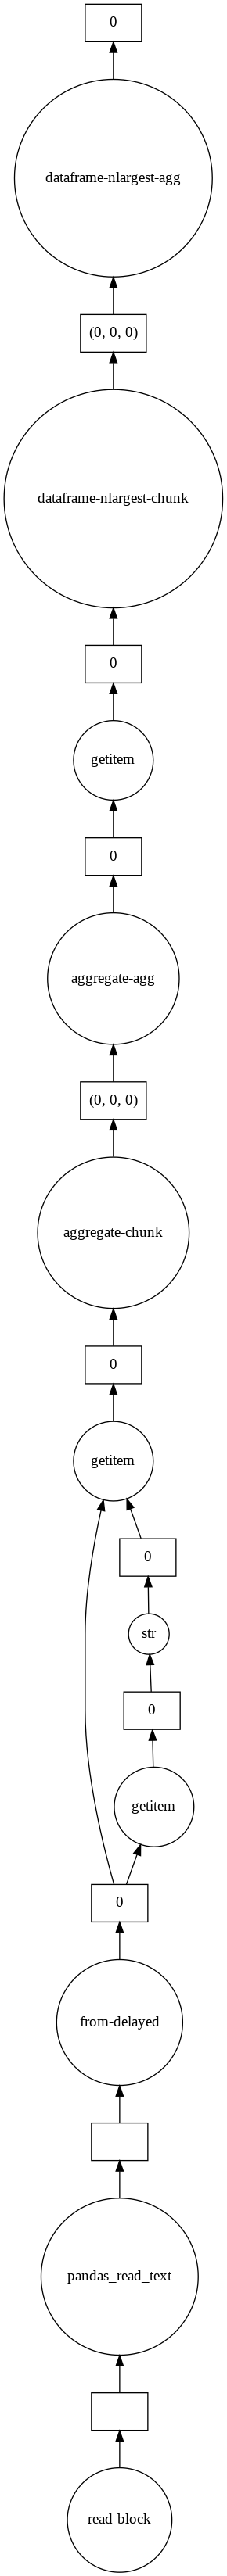

In [ ]:
mean_ipa_review.nlargest(20, 'mean').visualize()

In [ ]:
client.close()

## Dask Plot

你当然可以`df.compute()`转化为pandas dataframe然后各种画图，也可以使用`hvplot`库

In [ ]:
import numpy as np
#import hvplot.pandas  # noqa
#import hvplot.dask  # noqa

In [ ]:
ddf.head(3)

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,784200,952,Great Dane Pub & Brewing Company (Downtown),1136269921,4.5,4.0,4.0,dirtylou,American IPA,4.0,4.0,Texas Speedbump IPA,NaN,11846
1,1305265,29,Anheuser-Busch,1234830966,4.5,4.0,3.0,talkinghatrack,Light Lager,3.0,4.0,Bud Light Lime,4.2,41821
2,1526298,45,Brooklyn Brewery,1078599557,4.5,4.0,4.0,PopeJonPaul,Scotch Ale / Wee Heavy,4.0,4.5,Brooklyn Heavy Scotch Ale,7.5,16355


In [ ]:
type(ddf)

dask.dataframe.core.DataFrame

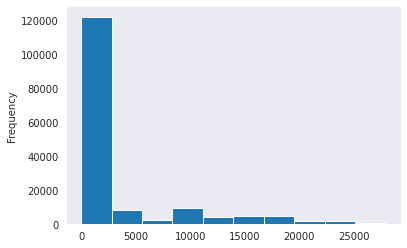

In [ ]:
ddf.brewery_id.compute().plot(kind = 'hist')

## Dask Persist

In [ ]:
df = pd.DataFrame({'x': [1, 2, 3, 4, 5],
                   'y': [1., 2., 3., 4., 5.]})
ddf = dd.from_pandas(df, npartitions=2)

In [ ]:
ddf.head()

/usr/local/lib/python3.7/dist-packages/dask/dataframe/core.py:5970: UserWarning: Insufficient elements for `head`. 5 elements requested, only 3 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,x,y
0,1,1.0
1,2,2.0
2,3,3.0


不使用`persist`

In [ ]:
ddf['y_sq'] = ddf.y.map(lambda x: x**2)
ddf['y_sq_sq'] = ddf.y_sq.map(lambda x: x**2)

ddf.head()

/usr/local/lib/python3.7/dist-packages/dask/dataframe/core.py:5970: UserWarning: Insufficient elements for `head`. 5 elements requested, only 3 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,x,y,y_sq,y_sq_sq
0,1,1.0,1.0,1.0
1,2,2.0,4.0,16.0
2,3,3.0,9.0,81.0


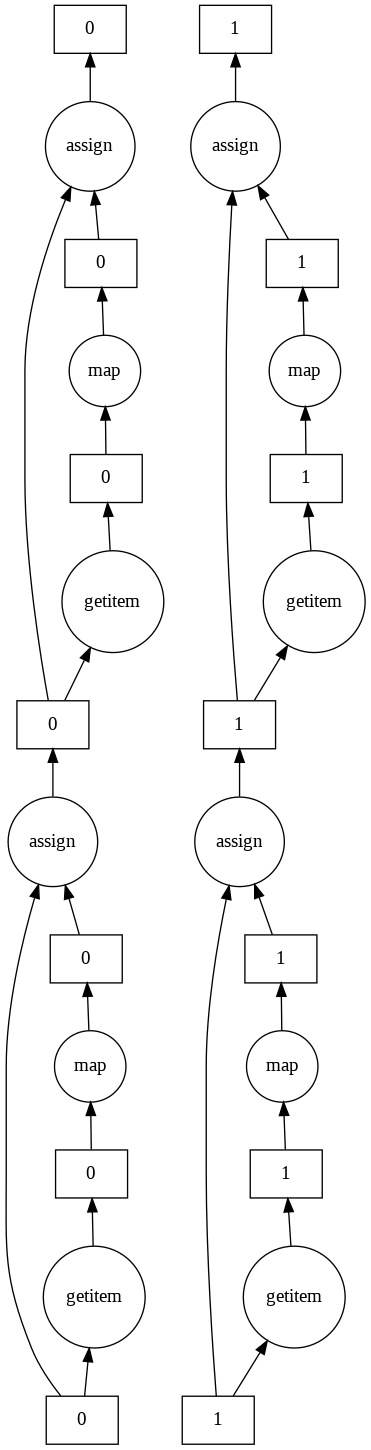

In [ ]:
ddf.visualize()

使用persist

In [ ]:
df = pd.DataFrame({'x': [1, 2, 3, 4, 5],
                   'y': [1., 2., 3., 4., 5.]})

ddf = dd.from_pandas(df, npartitions=2)

ddf['y_sq'] = ddf.y.map(lambda x: x**2)

In [ ]:
#ddf = client.persist(ddf)
ddf = ddf.persist()

In [ ]:
ddf['y_sq_sq'] = ddf.y_sq.map(lambda x: x**2)

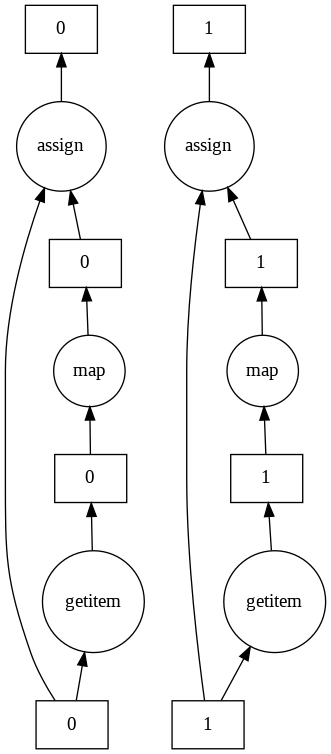

In [ ]:
ddf.visualize()

## Lab: Load Terabyte of Artificial Data

In [ ]:
import dask.dataframe as dd

df = dd.demo.make_timeseries(start='2010-12-30',
                             end='2010-12-31',
                             dtypes={'x': float, 'y': float, 'id': int},
                             freq='10ms',
                             partition_freq='24h')
df

,id,x,y
npartitions=1,,,
2010-12-30,int64,float64,float64
2010-12-31,...,...,...


In [ ]:
df = df.persist()

In [ ]:
%time df.groupby('id')[['x', 'y']].mean().compute()

CPU times: user 580 ms, sys: 143 ms, total: 724 ms
Wall time: 480 ms


,x,y
id,,
838,0.519674,-0.969971
839,0.385939,-0.642862
844,0.205217,-0.460795
847,-0.430286,-0.254284
848,-0.164064,0.159602
...,...,...
1155,0.242705,0.712045
1156,0.283108,0.588416
1157,-0.752265,0.151414


In [ ]:
df.x.rolling('1min').std().loc['2000-01-02':'2010-12-30'].idxmax().compute()

Timestamp('2010-12-30 00:00:00.010000')

In [ ]:
import dask.array as da
u, s, v = da.linalg.svd(df.values + 1)
s

dask.array<getitem-d2914c92ec8220a0d20395fe1ea0d8eb, shape=(3,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>

# Dask Array

In [ ]:
import numpy as np
import dask.array as da

In [ ]:
client = Client(n_workers = 2, 
                threads_per_worker = 1, 
                memory_limit = '1GB'
                )
#client = Client()
client

Client Scheduler: tcp://127.0.0.1:46277 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 2.00 GB


In [ ]:
a_np = np.arange(1, 50, 3)
a_np

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49])

In [ ]:
a_da = da.arange(1, 50, 3, chunks = 5)
a_da

dask.array<arange, shape=(17,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

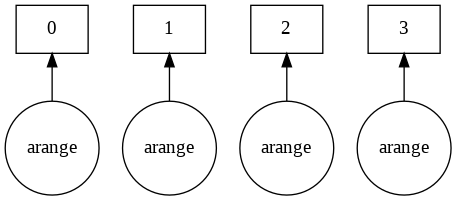

In [ ]:
a_da.visualize()

In [ ]:
print(a_da.dtype)
print(a_da.shape)

int64
(17,)


In [ ]:
print(a_da.chunks)
print(a_da.chunksize)

((5, 5, 5, 2),)
(5,)


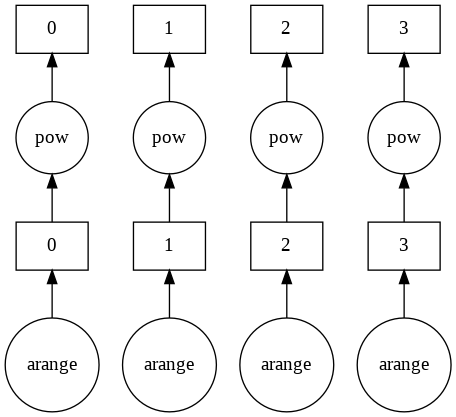

In [ ]:
(a_da**2).visualize()

In [ ]:
(a_da**2).compute()

array([   1,   16,   49,  100,  169,  256,  361,  484,  625,  784,  961,
       1156, 1369, 1600, 1849, 2116, 2401])

In [ ]:
type((a_da**2).compute())

numpy.ndarray

In [ ]:
x = da.random.random(20, chunks = 5)
x

dask.array<random_sample, shape=(20,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

In [ ]:
x.compute()

array([0.64349306, 0.77111578, 0.86580804, 0.02063362, 0.88172387,
       0.23060632, 0.45251844, 0.20758873, 0.43471983, 0.96179269,
       0.47552392, 0.44551783, 0.72067705, 0.88130295, 0.08787702,
       0.42711951, 0.2517945 , 0.82457253, 0.55446819, 0.92166395])

In [ ]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

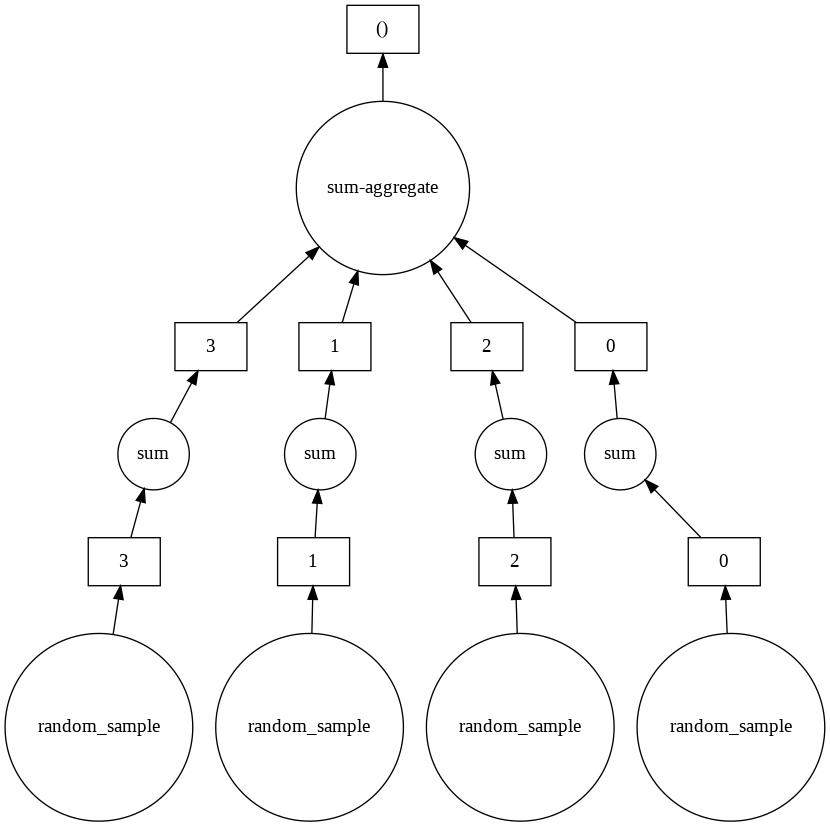

In [ ]:
result.visualize()

In [ ]:
result.compute()

11.060517825029777

In [ ]:
x = da.random.random(size = (20_000, 20_000), chunks = (2_000, 2_000))
x

dask.array<random_sample, shape=(20000, 20000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

我们可以看到这个dask array的size已经超过了我们的memory的size (2gb).

In [ ]:
result = (x + x.T).sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

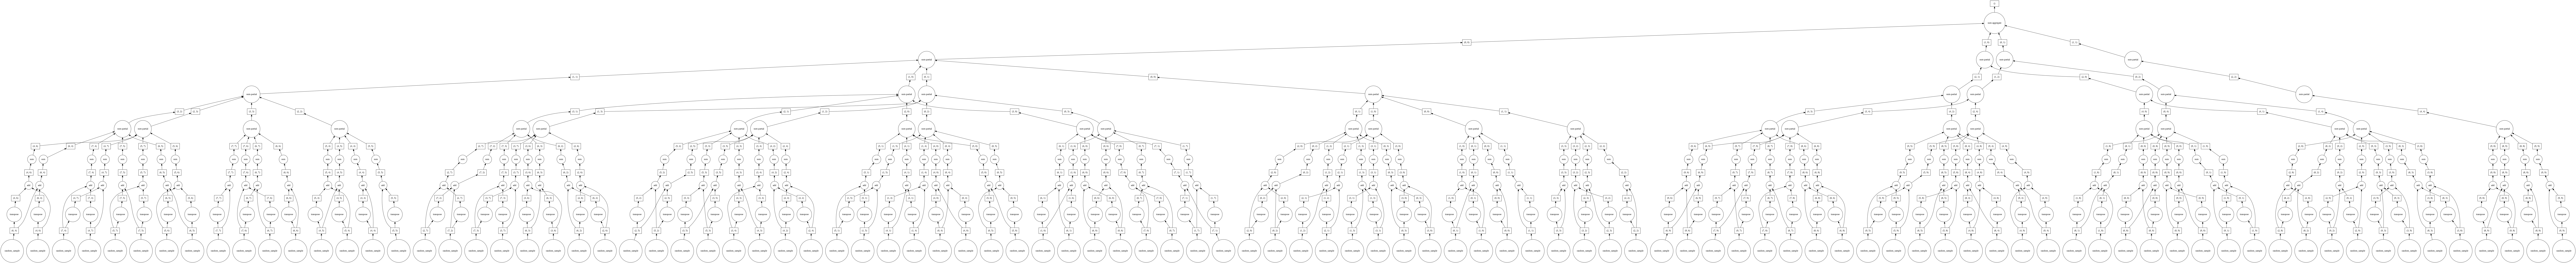

In [ ]:
result.visualize()

In [ ]:
result.compute()

399986562.77922606

# Dask ML

In [ ]:
import seaborn as sns
import dask.dataframe as dd

df = sns.load_dataset('diamonds')
#df.head()

In [ ]:
ddf = dd.from_pandas(df, npartitions=3)

In [ ]:
ddf.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
# categorize some columns
ddf = ddf.categorize()
ddf

,carat,cut,color,clarity,depth,table,price,x,y,z
npartitions=3,,,,,,,,,,
0,float64,category[known],category[known],category[known],float64,float64,int64,float64,float64,float64
17980,...,...,...,...,...,...,...,...,...,...
35960,...,...,...,...,...,...,...,...,...,...
53939,...,...,...,...,...,...,...,...,...,...


In [ ]:
# get dummy data for categorical features

prepared = dd.reshape.get_dummies(ddf)
prepared

,carat,depth,table,price,x,y,z,cut_Ideal,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
npartitions=3,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,int64,float64,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8
17980,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35960,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53939,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
from sklearn.pipeline import make_pipeline
from dask_ml.preprocessing import Categorizer, DummyEncoder
from dask_ml.linear_model import LinearRegression

pipe = make_pipeline(
    Categorizer(),
    DummyEncoder()
)

pipe.fit(ddf)

prepared = pipe.transform(ddf)

ContextualVersionConflict: ignored

In [ ]:
prepared.head()

,carat,depth,table,price,x,y,z,cut_Ideal,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
0,0.23,61.5,55.0,326,3.95,3.98,2.43,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
# label array
y = prepared.price.to_dask_array(lengths = True)
y

dask.array<values, shape=(53940,), dtype=int64, chunksize=(17980,), chunktype=numpy.ndarray>

In [ ]:
# feature array
arr = prepared.drop('price', axis = 1).to_dask_array(lengths = True)
arr

dask.array<values, shape=(53940, 26), dtype=float64, chunksize=(17980, 26), chunktype=numpy.ndarray>

In [ ]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(arr, y, test_size = 0.2)

X_train

dask.array<concatenate, shape=(43152, 26), dtype=float64, chunksize=(14384, 26), chunktype=numpy.ndarray>

In [ ]:
y_train

dask.array<concatenate, shape=(43152,), dtype=int64, chunksize=(14384,), chunktype=numpy.ndarray>

In [ ]:
from dask_ml.linear_model import LinearRegression

lr = LinearRegression(solver='lbfgs', max_iter=10)
lr_model = lr.fit(X_train, y_train)

ContextualVersionConflict: ignored

In [ ]:
lr_model.coef_

NameError: ignored

In [ ]:
y_predicted = lr_model.predict(X_test)
y_predicted

In [ ]:
y_test

In [ ]:
from dask_ml.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(y_test, y_predicted))

# Dask Bag

A **Bag** is an unirdered collection taht can contain the same item multiple times (unlike a Python set, which cannot distinguish duplicates). A **Bag** is a little big like a python Counter.

But the main feature is that it can be partitioned and processed in parallel.

**Bag**最大的问题是是无序的，也就是你不能indexing。

In [ ]:
 import dask.bag as db

In [ ]:
b = db.from_sequence([1,2,3,3,4, 5, 6, 4, 3, 2, 2, 2], npartitions= 4)

In [ ]:
b.compute()

[1, 2, 3, 3, 4, 5, 6, 4, 3, 2, 2, 2]

In [ ]:
type(b.compute())

list

In [ ]:
b

dask.bag<from_sequence, npartitions=4>

In [ ]:
b.sum().compute()

37

In [ ]:
b.npartitions

4

In [ ]:
b_squared_1 = b.map(lambda x:x**2)
#b_squared_2 = b.map_partitions(lambda x:x**2)

In [ ]:
#b_squared_1.compute()
b_squared_1.take(3)

(1, 4, 9)

In [ ]:
5%2

1

In [ ]:
even_odd_groups = b_squared_1.groupby(lambda x: x%2)

In [ ]:
even_odd_groups.compute()

[(0, [4, 16, 36, 16, 4, 4, 4]), (1, [1, 9, 9, 25, 9])]

In [ ]:
even_odd_groups.take(1)[0][1]

[4, 16, 36, 16, 4, 4, 4]

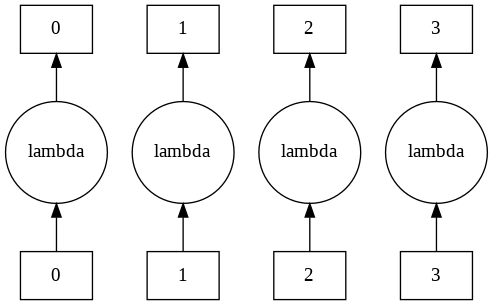

In [ ]:
# 可以看到也是multiprocessing
b_squared_1.visualize()

# Dask Delayed

In [ ]:
import time

def inc(x):
    time.sleep(0.5)
    return x + 1

def double(x):
    time.sleep(0.5)
    return 2 * x

def add(x, y):
    time.sleep(0.5)
    return x + y

In [ ]:
%%time

data = [1, 2, 3, 4]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)

CPU times: user 310 ms, sys: 34.1 ms, total: 344 ms
Wall time: 6.01 s



Dask `delayed` wraps function calls and delays their execution. Rather than computing results immediately, `delayed` functions record what we want to compute as a task into a graph that we’ll run later on parallel hardware by calling compute.

其实`delayed`就是将所有的运算暂时储存起来，一个个放入图中，等图被创建完了，再并行计算

In [ ]:
from dask import delayed

In [ ]:
lazy_inc = delayed(inc)
inc_output = lazy_inc(3)  #inc(3)
inc_output

Delayed('inc-3c86d778-6884-4be5-bd5c-9ad08732ffb4')

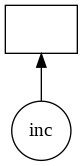

In [ ]:
inc_output.visualize()

In [ ]:
@delayed
def inc(x):
    time.sleep(0.5)
    return x + 1

@delayed
def double(x):
    time.sleep(0.5)
    return 2 * x

@delayed
def add(x, y):
    time.sleep(0.5)
    return x + y

In [ ]:
%%time

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = delayed(sum)(output)
total

CPU times: user 1.61 ms, sys: 924 µs, total: 2.53 ms
Wall time: 2.39 ms


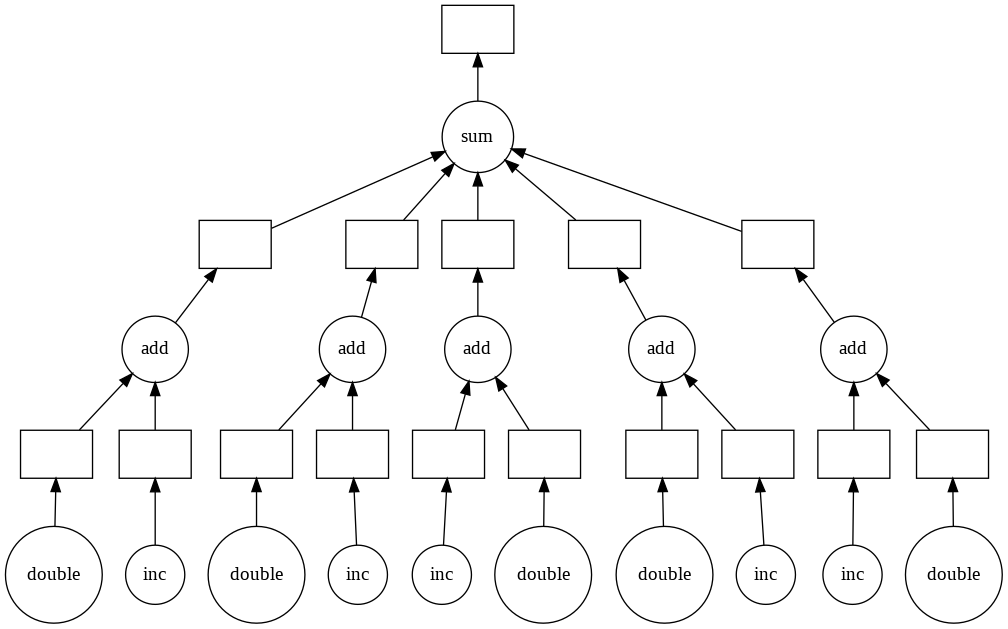

In [ ]:
total.visualize()

In [ ]:
%%time

total.compute()

CPU times: user 254 ms, sys: 33.4 ms, total: 287 ms
Wall time: 4.05 s


50

`Delayed`这玩意儿坑挺多的，还是参照下best practice比较好

Check out the [Dask delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) page to avoid some common problems when using delayed.



# Dask Futures

In [ ]:
import time
def inc(x):
  time.sleep(1)
  return x+1

In [ ]:
from distributed import Client, LocalCluster
import numpy as np
import time

# cluster = LocalCluster()
# client = Client(cluster)

client = Client()
client

/usr/local/lib/python3.7/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36685 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:41521 Dashboard: http://127.0.0.1:36685/status,Cluster Workers: 2 Cores: 2 Memory: 13.62 GB


In [ ]:
%%time
inputs = [1,2,3,4,5,6,7,8,9,10]*2
futures = []

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 25.7 µs


In [ ]:
%%time

# 一般版本 
for i in inputs:
  future = inc(i)
  futures.append(future)
  total = np.sum(futures)

total

CPU times: user 1.74 s, sys: 279 ms, total: 2.02 s
Wall time: 20 s


In [ ]:
%%time
inputs = [1,2,3,4,5,6,7,8,9,10]*2
futures = []

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.4 µs


In [ ]:
%%time

# dask for loop版本
for i in inputs:
  future = client.submit(inc, i)
  futures.append(future)
  total = client.submit(np.sum, futures)

CPU times: user 15.3 ms, sys: 3.07 ms, total: 18.4 ms
Wall time: 23.4 ms


In [ ]:
%%time

results = [future.result() for future in futures]
results

CPU times: user 512 ms, sys: 61.2 ms, total: 573 ms
Wall time: 5.06 s


In [ ]:
total.result()

130

In [ ]:
%%time

def plus_one(x):
  time.sleep(0.1)
  return x+1

# dask list comprehension版本
L = [client.submit(inc, i) for i in range(200)]
#L2 = [client.submit(process, x) for x in futures]
L2 = client.map(plus_one, L)
L3 = client.map(plus_one, L2)

CPU times: user 74.2 ms, sys: 6.51 ms, total: 80.7 ms
Wall time: 88.3 ms


In [ ]:
L[:5]

[<Future: pending, key: inc-e2db3db6261aa7dc46e79e4dcfc5b345>,
 <Future: finished, type: builtins.int, key: inc-02a2d9c7a4ac75d09428aa192b059dde>,
 <Future: finished, type: builtins.int, key: inc-6b238b27914474aeaafebd2f5b5e49a7>,
 <Future: finished, type: builtins.int, key: inc-757d5abe1f731e5d94181111f93f8607>,
 <Future: finished, type: builtins.int, key: inc-2e3619734df3f8b6caa6a1447c474646>]

In [ ]:
L[2].result()

3

In [ ]:
del L

# Dask Distributed (Multi-Machine)

In [ ]:
from dask.distributed import LocalCluster, Client

In [ ]:
cluster = LocalCluster()
cluster

/usr/local/lib/python3.7/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41439 instead
  http_address["port"], self.http_server.port


In [ ]:
# 可以看到cluster，scheduler以及各个worker的信息
cluster.get_logs()

{'Cluster': '',
 'Scheduler': "distributed.scheduler - INFO - Clear task state\ndistributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:37009\ndistributed.scheduler - INFO -   dashboard at:           127.0.0.1:41439\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:42701', name: 1, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:42701\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:33295', name: 0, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:33295",
 'tcp://127.0.0.1:33295': 'distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:33295\ndistributed.worker - INFO -          Listening to:      tcp://127.0.0.1:33295\ndistributed.worker - INFO -          dashboard at:            127.0.0.1:38319\ndistributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:37009\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -               Threads:                          1\ndistributed.worker - INFO -                Memory:                    6.81 GB\ndistributed.worker - INFO -       Local Directory: /content/dask-worker-space/dask-worker-space/worker-t1pc54kq\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -         Registered to:      tcp://127.0.0.1:37009\ndistributed.worker - INFO - -------------------------------------------------',
 'tcp://127.0.0.1:42701': 'distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:42701\ndistributed.worker - INFO -          Listening to:      tcp://127.0.0.1:42701\ndistributed.worker - INFO -          dashboard at:            127.0.0.1:44563\ndistributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:37009\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -               Threads:                          1\ndistributed.worker - INFO -                Memory:                    6.81 GB\ndistributed.worker - INFO -       Local Directory: /content/dask-worker-space/dask-worker-space/worker-k4_hz0hw\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -         Registered to:      tcp://127.0.0.1:37009\ndistributed.worker - INFO - -------------------------------------------------'}

In [ ]:
cluster.dashboard_link

'http://127.0.0.1:41439/status'

In [ ]:
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37009 Dashboard: http://127.0.0.1:41439/status,Cluster Workers: 2 Cores: 2 Memory: 13.62 GB


## Remote clusters via SSH

A common way to distribute your work onto multiple machines is via SSH. Dask has a cluster manager which will handle creating SSH connections for you called `SSHCluster`.

```
from dask.distributed import SSHCluster
```

When constructing this cluster manager we need to pass a list of addresses, either hostnames or IP addresses, which we will SSH into and attempt to start a Dask scheduler or worker on.

```
cluster = SSHCluster(["localhost", "hostA", "hostB"])
cluster
```
When we create our SSHCluster object we have given a list of three hostnames.

The first host in the list will be used as the scheduler, all other hosts will be used as workers. If you're on the same network it wouldn't be unreasonable to set your local machine as the scheduler and then use other machines as workers.

If your servers are remote to you, in the cloud for instance, you may want the scheduler to be a remote machine too to avoid network bottlenecks.


## Scalable clusters

Both of the clusters we have seen so far are fixed size clusters. We are either running locally and using all the resources in our machine, or we are using an explicit number of other machines via SSH.

With some cluster managers it is possible to increase and descrease the number of workers either by calling cluster.scale(n) in your code where n is the desired number of workers. Or you can let Dask do this dynamically by calling cluster.adapt(minimum=1, maximum=100) where minimum and maximum are your preferred limits for Dask to abide to.

It is always good to keep your minimum to at least 1 as Dask will start running work on a single worker in order to profile how long things take and extrapolate how many additional workers it thinks it needs. Getting new workers may take time depending on your setup so keeping this at 1 or above means this profilling will start immediately.

We currently have cluster managers for Kubernetes, Hadoop/Yarn, cloud platforms and batch systems including PBS, SLURM and SGE.

These cluster managers allow users who have access to resources such as these to bootstrap Dask clusters on to them. If an institution wishes to provide a central service that users can request Dask clusters from there is also Dask Gateway.